# TW - assignment 

- What are the main issues the CX team have? 
- Which market is performing best?
- Do senior agents perform better?
- We have a target of replying within 5 mins, how are we doing?
- Notes of other data that would be useful / future ideas

### Data preparation and cleaning

In [ ]:
# importing libraries and format needed
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
%precision %.2f
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
sns.set()

In [ ]:
df=pd.read_excel('CX_test.xlsx', header=1)  # opening 1st sheet and saving it as df)

In [ ]:
print('duplicates:', df.duplicated().sum())  # checking dublication, but not taking any action

duplicates: 8579


In [ ]:
# changing columns format, deleteng unnecesary column and changing some column names
df.columns = df.columns.str.lower().str.replace(' ','_')
df = df.drop(columns=['unnamed:_0'])
df=df.rename(
    columns={'tickets_is_answered_(yes_/_no)':'tickets_is_answered','_ticket_category':'ticket_category','total_time_spent_(s)':'total_time_spent_sec','_agent_is_senior_(yes_/_no)':'agent_is_senior','_first_reply_time_in_minutes_business':'first_reply_time_min', '_first_resolution_time_in_minutes_business':'first_resolution_time_min'})

In [ ]:
df.head(5) # checking first 5 rows of the tab

,contact_source,country,tickets_is_answered,ticket_category,total_time_spent_sec,agent_is_senior,first_reply_time_min,first_resolution_time_min
0,email_outbound,United Kingdom,Yes,misc,2639,No,100,2183
1,email_inbound,Belgium,Yes,finance,360,No,168,1386
2,call_inbound,United Kingdom,No,spa,2401,No,0,318
3,call_inbound,Germany,No,finance,117,No,0,2
4,call_inbound,United Kingdom,No,cancellation,785,No,0,21


In [ ]:
# checking missing data
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
contact_source,0.000000
country,0.460000
tickets_is_answered,0.000000
ticket_category,4.080000
total_time_spent_sec,0.000000
agent_is_senior,0.000000
first_reply_time_min,0.000000
first_resolution_time_min,0.000000


In [ ]:
df['ticket_category']=df['ticket_category'].fillna('undefined') # chaning missing data in 'ticket_category' to "undefined"
df=df.dropna(subset=['country']) # deleing rows without information on ' country' (its percentage is very low)

In [ ]:
# here I have been checking on categories, duplicates inside them, it-s hidden as output is quite big
#for row in df:
    #print(df[row].unique()) 
    #print(df[row].value_counts()) 

In [ ]:
# changing some names in categories after previos exploration
df.loc[df['ticket_category'] == 'gift_card_-_e-voucher', 'ticket_category'] = 'gift_card_-_evoucher'
df.loc[df['ticket_category'] == 'cancellation_partner_didn‚Äôt_inform_customer_', 'ticket_category'] = 'cancel_partner_not_informed_cust'
df.loc[df['contact_source'] == 'other_ticket___dc.submit_request__', 'contact_source'] = 'other_ticket_dc.submit'

In [ ]:
# opening 2nd sheet of the file and saving it as df_country, adding % on headcount per country
df_country=pd.read_excel('CX_test.xlsx',sheet_name='country data', header=1, index_col=None) 
df_country.columns = df_country.columns.str.lower().str.replace(' ','_')
df_country = df_country.drop(columns=['unnamed:_0','unnamed:_3'])
df_country['%_headcount']=(df_country['headcount']/df_country['headcount'].sum()*100)
df_country=df_country.sort_values('%_headcount', ascending=False).reset_index(drop=True) 
df_country.loc[df_country['country'] == 'UK', 'country'] = 'United Kingdom'

In [ ]:
df_country

,country,headcount,%_headcount
0,Spain,50,33.11
1,Austria,20,13.25
2,Lithuania,20,13.25
3,Ireland,15,9.93
4,United Kingdom,10,6.62
5,Belgium,10,6.62
6,Netherlands,10,6.62
7,Switzerland,7,4.64
8,Germany,5,3.31
9,France,3,1.99


## What are the main issues the CX team have?

#### Contact sources

In [ ]:
# contact_source tab
contact_source = df.groupby('contact_source')['contact_source'].agg(['count'])
contact_source['%_count']=contact_source['count']/contact_source['count'].sum()*100
contact_source=contact_source.sort_values('count', ascending=False).reset_index() 
contact_source

,contact_source,count,%_count
0,call_inbound,20758,48.79
1,email_inbound,15117,35.53
2,email_outbound,3928,9.23
3,call_outbound,916,2.15
4,other_ticket_chat,646,1.52
5,other_ticket_nps,514,1.21
6,other_ticket_,285,0.67
7,other_ticket_twitter,177,0.42
8,other_ticket_facebook,155,0.36
9,other_ticket_dc.submit,47,0.11


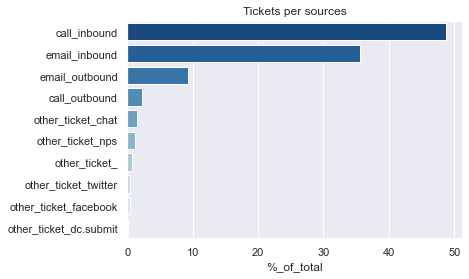

In [ ]:
sns.barplot(y=contact_source['contact_source'], x=contact_source['%_count'], palette='Blues_r')
plt.title('Tickets per sources')
plt.xlabel('%_of_total')
plt.ylabel('')
plt.show()

Almost 50% of the tickets were created after inbound call, and 36% after inbound email. 9% of the tickets has outbound email as contact source, and 2% has outbound calls as a origin. That means that 11% of the tickets were started from agents side. Chat was contact source in 1.5%.
So the preferred way of contact is by phone, followed by email. This means that phone coverage, awating time and average call time are extremely important. 

#### Countries

In [ ]:
# creating country tab
country = df.groupby('country')['country'].agg(['count'])
country['%_count']=country['count']/country['count'].sum()*100
country=country.sort_values('count', ascending=False).reset_index() 
country

,country,count,%_count
0,United Kingdom,20971,49.29
1,Netherlands,5837,13.72
2,Germany,4890,11.49
3,France,4415,10.38
4,Spain,1759,4.13
5,Belgium,1265,2.97
6,Italy,972,2.28
7,Austria,857,2.01
8,Ireland,652,1.53
9,Switzerland,618,1.45


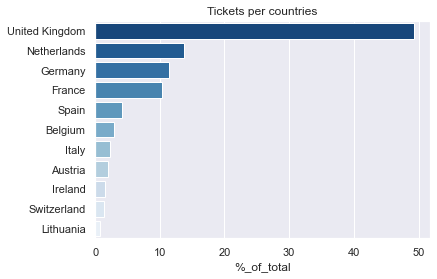

In [ ]:
sns.barplot(y=country['country'], x=country['%_count'], palette='Blues_r')
plt.title('Tickets per countries')
plt.xlabel('%_of_total')
plt.ylabel('')
plt.show()

Half of all tickets were from UK users (49%), followed by users from Netherlands (14%), Germany (12%) and France (10%).

In [ ]:
# merging previous tab with tab on headcounts in order to compare tickets% and headcount per country
country_total=country.merge(df_country, on='country').sort_values('%_count', ascending=False).drop(columns=['headcount'])
country_total

,country,count,%_count,%_headcount
0,United Kingdom,20971,49.29,6.62
1,Netherlands,5837,13.72,6.62
2,Germany,4890,11.49,3.31
3,France,4415,10.38,1.99
4,Spain,1759,4.13,33.11
5,Belgium,1265,2.97,6.62
6,Italy,972,2.28,0.66
7,Austria,857,2.01,13.25
8,Ireland,652,1.53,9.93
9,Switzerland,618,1.45,4.64


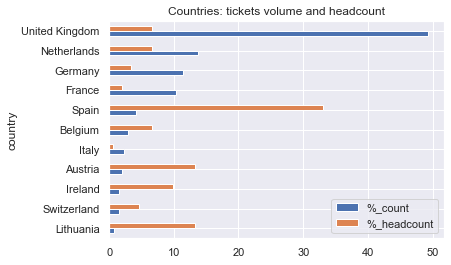

In [ ]:
country_total.sort_values('%_count').plot.barh(x='country', y=['%_count','%_headcount',], title="Countries: tickets volume and headcount")
plt.xlabel('');

Tickets from users from UK, Netherlands, Germany and France have more volumes that the headcount proportions for these countries, and the opposite is happening with Spain and Lithuania. Belgium, Austria, Ireland and Switzerland surely are covering needs of the markets with less native agents, but probably not completely and some language tickets can have more waiting time. For the full undersanding we need more information on laguages of agents and ticket language.

#### Ticket categories

In [ ]:
# ticket_category tab
ticket_category = df.groupby('ticket_category')['ticket_category'].agg(['count'])
ticket_category['%_count']=ticket_category['count']/contact_source['count'].sum()*100
ticket_category=ticket_category.sort_values('count', ascending=False).reset_index() 
ticket_category.head(10)

,ticket_category,count,%_count
0,cancellation,11521,27.08
1,profile,7079,16.64
2,misc,5799,13.63
3,finance,3310,7.78
4,complaint,2617,6.15
5,other,2001,4.70
6,new_or_existing_order,1656,3.89
7,undefined,1544,3.63
8,spa,1301,3.06
9,promo_code,1009,2.37


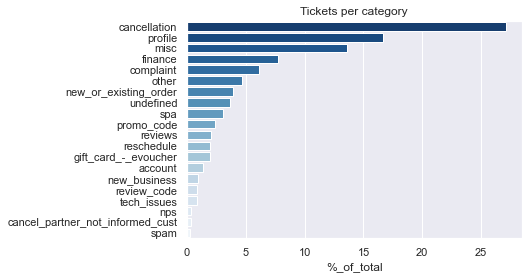

In [ ]:
sns.barplot(y=ticket_category['ticket_category'], x=ticket_category['%_count'], palette='Blues_r')
plt.title('Tickets per category')
plt.xlabel('%_of_total')
plt.ylabel('')
plt.show()

The most popular ticket category is cancellation, with 27% from all tickets, followed by tickets related to profile questions with 17%. The third most frequent category is misclassified, with 13.63%. It should be noticed, that the is also "other" category with 4.7 and "undefined" (which is the label for missing values) with 3.63%. All together unknown ticket topics sums 22%, which is quite high and we might have to look better into the ticket categorization and ticket topics. 
It should be noted that cancellation tickets can be more time consuming and increase handling time.

#### Agents tenure

In [ ]:
agent = df.groupby('agent_is_senior')['agent_is_senior'].agg(['count'])
agent['%_count']=agent['count']/agent['count'].sum()*100
agent.sort_values('count', ascending=False)

,count,%_count
agent_is_senior,,
No,38709,90.99
Yes,3834,9.01


9% of all tickets were handled by senior agents.

#### Answered tickets

In [ ]:
tickets_is_answered = df.groupby('tickets_is_answered')['tickets_is_answered'].agg(['count'])
tickets_is_answered['%_count']=tickets_is_answered['count']/tickets_is_answered['count'].sum()*100
tickets_is_answered.sort_values('count', ascending=False)

,count,%_count
tickets_is_answered,,
No,28510,67.01
Yes,14033,32.99


33% of all tickets are answered, that means that the vast majority are so called 'no follow-up tickets', created and solved without the written answer from the agent. This can be a sigh of high efficency if all the issues were corretly addressed. These tickets should have lower handling time, which is to be checked.

#### Total time spent 

In [ ]:
# adding column total_time_spent_min in minutes
df['total_time_spent_min']=df['total_time_spent_sec']/60

In [ ]:
df[['total_time_spent_min']].describe()

,total_time_spent_min
count,42543.00
mean,6.35
std,19.72
min,0.00
25%,0.82
50%,2.80
75%,6.73
max,2284.22


In [ ]:
# % of total spent time on ticket with more than 20 minutes 
df[df['total_time_spent_min']>20]['total_time_spent_min'].count()/df['total_time_spent_min'].count()*100

6.109113132595256

Total time spent on ticket counts the active time agent works on the open ticket. Here we observe ouliers (maximum time is 38 hours, which could have been a technical issue or a very special case), so better metrics ot reflect the average time spent on ticket is median (and not the mean), it's 2.8 minutes. Around 6% of the tickets needed more than 20 minutes. We have to identify the ouliers and investigate what happened with the tickets with the extreme high total spent time.

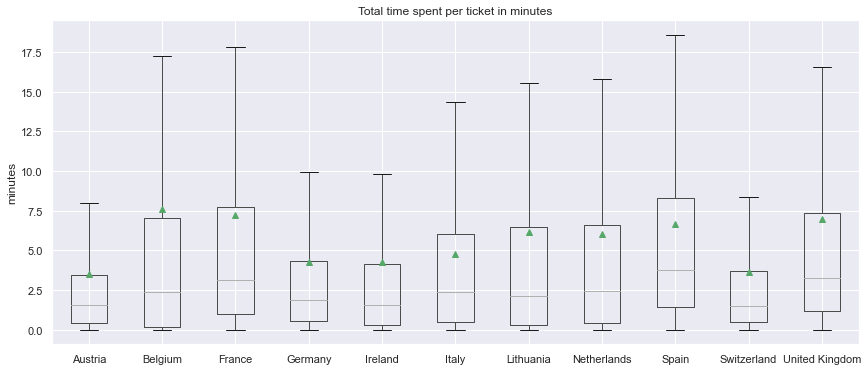

In [ ]:
# comparing total spent time by country (with removed from plot outliers)
df.boxplot(column=['total_time_spent_min'], by='country',figsize=(14,6),showmeans=True, showfliers=False )
plt.ylabel('minutes')
plt.xlabel('')
plt.title('Total time spent per ticket in minutes')
plt.suptitle("")
plt.show()

In [ ]:
country_total_time_spent_min=df.pivot_table(index=['country'], values='total_time_spent_min', aggfunc=(
    'median', 'mean')).sort_values('median', ascending=False)
country_total_time_spent_min

,mean,median
country,,
Spain,6.64,3.78
United Kingdom,6.98,3.27
France,7.21,3.15
Netherlands,6.05,2.45
Belgium,7.58,2.38
Italy,4.79,2.35
Lithuania,6.15,2.12
Germany,4.25,1.83
Ireland,4.25,1.55


Spain, UK and France have higher median time spent per ticket, being more than 3 minutes. Switzerland, Austria and Ireland are the quickest with around 1.5 minutes.

In [ ]:
df.pivot_table(index=['agent_is_senior'], values='total_time_spent_min', aggfunc=('median', 'mean')).sort_values('median', ascending=False)

,mean,median
agent_is_senior,,
No,6.45,2.88
Yes,5.37,2.05


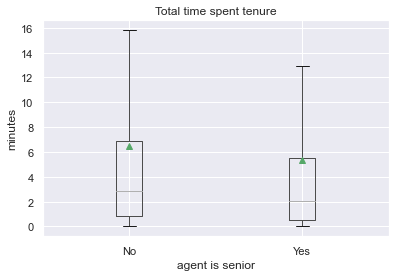

In [ ]:
# comparing total spent time by tenure (with removed from plot outliers)
df.boxplot(column=['total_time_spent_min'], by='agent_is_senior',showmeans=True, showfliers=False)
plt.ylabel('minutes')
plt.xlabel('agent is senior')
plt.title('Total time spent tenure')
plt.suptitle("")
plt.show()

Seniour agents are quicker that agents in terms of total spent time on ticket, with a difference of 50 seconds.

### Response time

In [ ]:
df[['first_reply_time_min']].describe()

,first_reply_time_min
count,42543.00
mean,153.32
std,510.69
min,0.00
25%,0.00
50%,0.00
75%,53.00
max,30018.00


In [ ]:
# tickets replied within 5 minutes or less
df[df['first_reply_time_min']<5]['first_reply_time_min'].count()/df['first_reply_time_min'].count()*100

67.64215029499564

In [ ]:
# tickets replied within 60  minutes or more
df[df['first_reply_time_min']>60]['first_reply_time_min'].count()/df['first_reply_time_min'].count()*100

24.398843523023764

In [ ]:
# tickets replied within 12  hours or more
df[df['first_reply_time_min']>12*60]['first_reply_time_min'].count()/df['first_reply_time_min'].count()*100

7.914345485743836

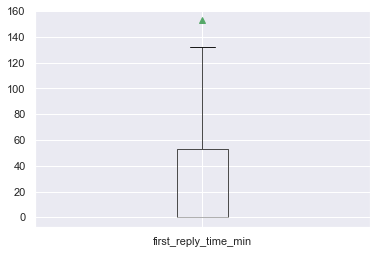

In [ ]:
df.boxplot(column=['first_reply_time_min'],showmeans=True, showfliers=False)
plt.show()

Here we also obsereve a lot of outliers, and average reply time is 153, because of it. Maximum is 20 days, this could have beean a technical issue or an extraordinary case. Again, the median time is better and it's a 0 which means in less than 0 minte, which is great response time.

As the target is 5 minutes, we are doing quite well. More than 67% of the tickets were replied within 5 minutes or less, which is great.
However, almost 25% of the tickets were replied within more than 1 hour, and 8% of the tickets within more than 12 hours.
We should check out the outliers and take an action in order to reduce the response time, as it's a crucial indicator for customer satisfacion. 

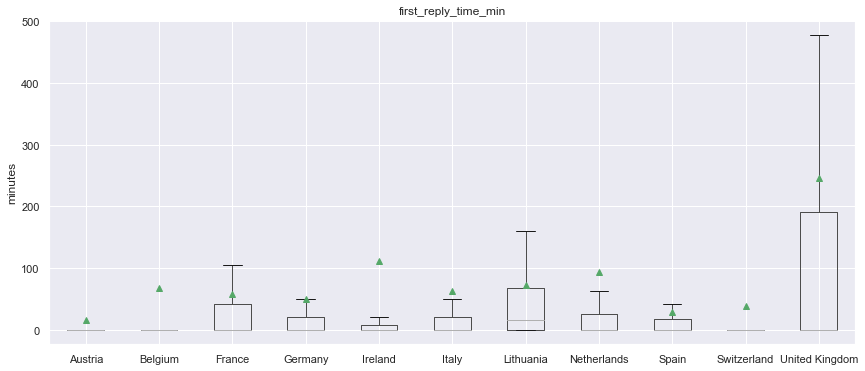

In [ ]:
# comparing resonse time by country (with removed from plot outliers)
df.boxplot(column=['first_reply_time_min'], by='country',figsize=(14,6),showmeans=True, showfliers=False)
plt.ylabel('minutes')
plt.xlabel('')
plt.title('first_reply_time_min')
plt.suptitle("")
plt.show()

In [ ]:
countries_first_reply_time_min=df.pivot_table(index=['country'], values='first_reply_time_min', aggfunc=(
    'median', 'mean')).sort_values('mean', ascending=False)
countries_first_reply_time_min

,mean,median
country,,
United Kingdom,246.02,0.00
Ireland,111.60,0.00
Netherlands,92.89,0.00
Lithuania,72.27,15.00
Belgium,67.35,0.00
Italy,63.19,0.00
France,57.64,0.00
Germany,48.87,0.00
Switzerland,37.66,0.00


We observe, that the only country wich has median more than 0 minues is Lithuania, so this market should be checked. It's a small market in terms of tickets (307, less than 1% of all tickets), and it has much more written interactions than calls, which impacted the median.
The boxplots per countries show that Austria is the quickest market to be replied, followed by Switzerland and Belgium.
UK market is a way different from the rest, it's time of response in the majority of cases were quite longer than for other markets, its maximum values (without outliers) are near 500 minutes

In [ ]:
# *checking on Lithuania tickets distribution of response time per channel
#df[df['country']=='Lithuania' ].groupby(
#    'contact_source')['first_reply_time_min'].agg(['sum','count']).sort_values('sum', ascending=False)

In [ ]:
df.pivot_table(index=['agent_is_senior'], values='first_reply_time_min', aggfunc=('median', 'mean')).sort_values('median', ascending=False)

,mean,median
agent_is_senior,,
Yes,214.01,10.00
No,147.31,0.00


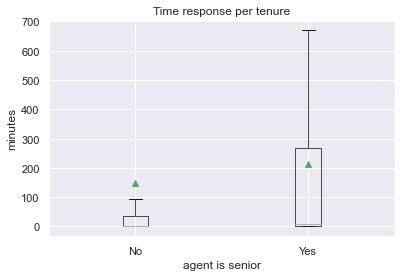

In [ ]:
# comparing response time by tenure (with removed from plot outliers)
df.boxplot(column=['first_reply_time_min'], by='agent_is_senior',showmeans=True, showfliers=False)
plt.ylabel('minutes')
plt.xlabel('agent is senior')
plt.title('Time response per tenure')
plt.suptitle("")
plt.show()

Tickets handled by seniour agents had quite much higher time response than of not tenured agens. Seniour have 10 minutes as median while agents have 0. Both groups have outliers, however the vast majority of seniour tickets were replied within more time comparing to the agents. This should be investigated further, as for now we have no information if the tickets seniours were handling are more complex, for example, or there is a lack of motivation and decrease of efficiency among most tenuered agents.

#### First resolution time

In [ ]:
df[['first_resolution_time_min']].describe()

,first_resolution_time_min
count,42543.00
mean,380.71
std,1168.58
min,0.00
25%,2.00
50%,7.00
75%,155.00
max,30018.00


First resolution time is the time passed from the ticket creation till agent solves the ticket for the first time (however, reopens can be possible, so it's not necessary the same that the total resolution time). The average is 380 minutes, however the median is 7 minutes, so there are a lot of outliers here as well. 75% of the tickets are solved for the first time within 155 minutes or less. In order to better evalute the results, we need to have some more information on targets, and how resolution works (does the ticket closes authomatically after solving, or some time should pass, are agents encouraged to put tickets on pending in case of dubt etc.). 

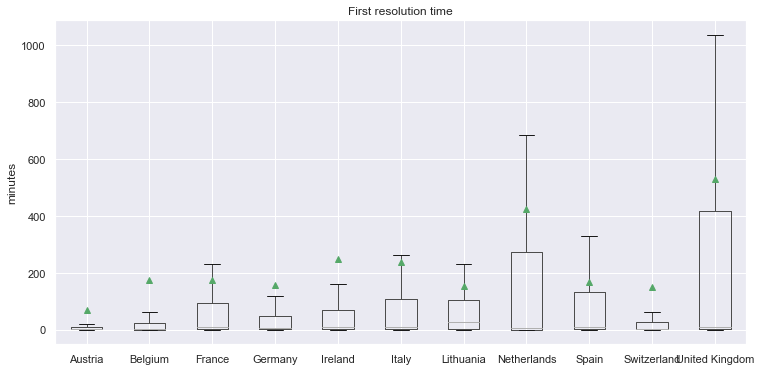

In [ ]:
# comparing first resolution time by country (with removed from plot outliers)
df.boxplot(column=['first_resolution_time_min'], by='country',figsize=(12,6),showmeans=True, showfliers=False)
plt.ylabel('minutes')
plt.xlabel('')
plt.title('First resolution time')
plt.suptitle("")
plt.show()

In [ ]:
country_first_resolution_time_min=df.pivot_table(index=['country'], values='first_resolution_time_min', aggfunc=(
    'median', 'mean')).sort_values('median', ascending=False)
country_first_resolution_time_min

,mean,median
country,,
Lithuania,153.83,25.00
Ireland,247.09,10.00
United Kingdom,528.59,10.00
France,175.44,9.00
Italy,237.07,8.00
Spain,166.66,8.00
Netherlands,422.12,6.00
Germany,157.56,4.00
Austria,70.23,3.00


Countries with the highest median time for the first resolutions are Lithuania, Ireland (the amount of tickets for these countries is low), UK and France, which both need some attention. The quickest resolutions countries are Belgium, Switzerland, Austria and Germany with median of 4 minutes or less.

In [ ]:
df.pivot_table(index=['agent_is_senior'], values='first_resolution_time_min', aggfunc=('median', 'mean')).sort_values('median', ascending=False)

,mean,median
agent_is_senior,,
Yes,511.65,74.50
No,367.74,6.00


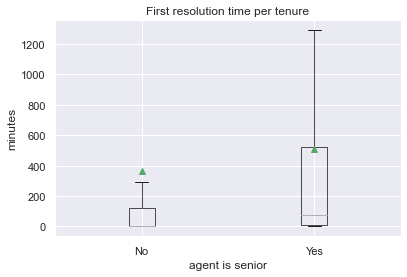

In [ ]:
# comparing first resolution time by country (with removed from plot outliers)
df.boxplot(column=['first_resolution_time_min'], by='agent_is_senior',showmeans=True, showfliers=False)
plt.ylabel('minutes')
plt.xlabel('agent is senior')
plt.title('First resolution time per tenure')
plt.suptitle("")
plt.show()

Seniour agents takes more time for the first resolution, with a median time 75 minutes against 6 minutes for agents. There is a big difference, so we need to investigate the causes of this behaviour.

### General tabs for conclusions on timing per country and timing per agents

In [ ]:
country_total_time=df.pivot_table(index=['country'], values=(
    'first_resolution_time_min','total_time_spent_min','first_reply_time_min'), aggfunc=(
    'median', 'mean')).sort_values(('first_resolution_time_min', 'median'))
with pd.option_context('display.precision', 2):
    country_total_time_gradient=country_total_time.style.background_gradient(cmap = 'Blues')

In [ ]:
agent_total_time=df.pivot_table(index=['agent_is_senior'], values=(
    'first_resolution_time_min','total_time_spent_min','first_reply_time_min'), aggfunc=(
    'median', 'mean')).sort_values(('first_resolution_time_min', 'median'))
with pd.option_context('display.precision', 2):
    agent_total_time_gradient=agent_total_time.style.background_gradient(cmap = 'Blues')

## Conclusions

*General findings and the main issues the CX team have*
- 50% of the tickets were created after inbound call, and 36% after inbound email. 
- 9% of the tickets has outbound email, 2% has outbound calls as an origin. 

- 49%  tickets were from UK users, 14% from Netherlands, 12% Germany and 10% France.
- More ticket volumes than the headcount proportions, the opposite for Spain and Lithuania. 

- Cancellation ticket category is 27% from all, profile questions - 17%. 
- 22% of tickets have no clear ticket topic. 

- 9% of all tickets were handled by senior agents.

- 33% of all tickets were answered, the rest are "no follow-up tickets", created and solved without the written answer from the agent.

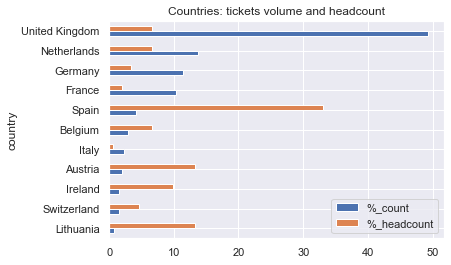

In [ ]:
country_total.sort_values('%_count').plot.barh(x='country', y=['%_count','%_headcount',], title="Countries: tickets volume and headcount")
plt.xlabel('');

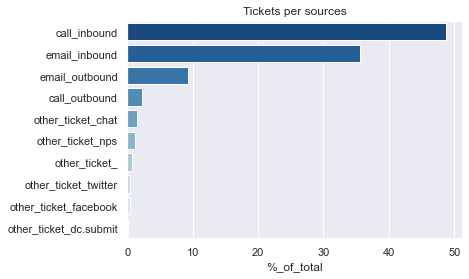

In [ ]:
sns.barplot(y=contact_source['contact_source'], x=contact_source['%_count'], palette='Blues_r')
plt.title('Tickets per sources')
plt.xlabel('%_of_total')
plt.ylabel('')
plt.show()

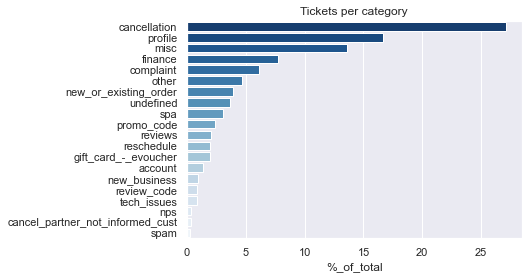

In [ ]:
sns.barplot(y=ticket_category['ticket_category'], x=ticket_category['%_count'], palette='Blues_r')
plt.title('Tickets per category')
plt.xlabel('%_of_total')
plt.ylabel('')
plt.show()

*Which market is performing best?*
- Data on ticket countires, not the country/market of handling agents. KPIs per ticket countries analysis.
- Austria is the quickest to be replied, followed by Switzerland and Belgium. 
- The quickest resolutions countries are Belgium, Switzerland, Austria and Germany. - - UK tickets time of response in the majority of cases were quite longer than for other markets.
- Spain, UK and France have higher median time spent per ticket, being more than 3 minutes. Switzerland, Austria and Ireland are the quickest with around 1.5 minutes.

In [ ]:
country_total_time_gradient

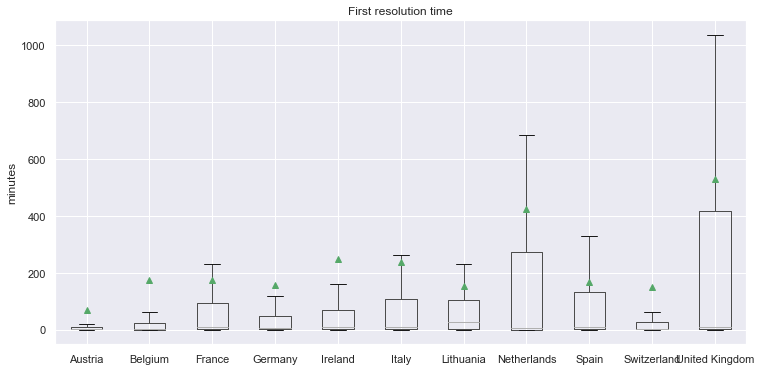

In [ ]:
# comparing first resolution time by country (with removed from plot outliers)
df.boxplot(column=['first_resolution_time_min'], by='country',figsize=(12,6),showmeans=True, showfliers=False)
plt.ylabel('minutes')
plt.xlabel('')
plt.title('First resolution time')
plt.suptitle("")
plt.show()

*Do senior agents perform better?*
- Seniour agents are better only in total time spent on tickets, median time is around 50 seconds less
- More tenured agents are much slower in first reply and in first resolution time, this should be investigated and adressed

In [ ]:
agent_total_time_gradient

We have a target of replying within 5 mins, how are we doing?

- Average reply time is 153 min because of outliers. Maximum is 20 days, this could have beean a technical issue 
- Median time is better metrics here, it's a 0 minutes, which is great response time.
- More than 67% of the tickets were replied within 5 minutes or less, which is great.
- Almost 25% of the tickets were replied within more than 1 hour, and 8% of the tickets within more than 12 hours.
- We should check out the outliers and take an action in order to reduce the response time, as it's a crucial indicator for customer satisfacion. 


In [ ]:
df[['first_reply_time_min']].describe()

,first_reply_time_min
count,42543.00
mean,153.32
std,510.69
min,0.00
25%,0.00
50%,0.00
75%,53.00
max,30018.00


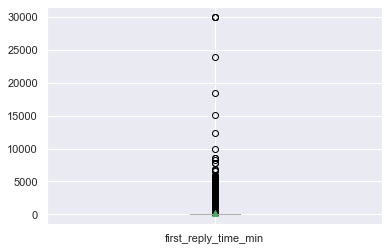

In [ ]:
df.boxplot(column=['first_reply_time_min'],showmeans=True, showfliers=True)
plt.show()

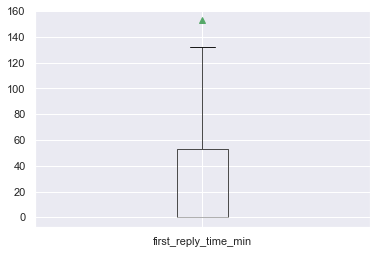

In [ ]:
df.boxplot(column=['first_reply_time_min'],showmeans=True, showfliers=False)
plt.show()

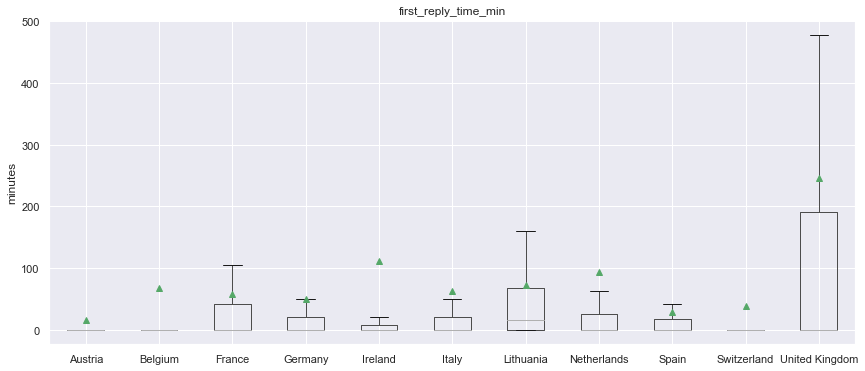

In [ ]:
# comparing resonse time by country (with removed from plot outliers)
df.boxplot(column=['first_reply_time_min'], by='country',figsize=(14,6),showmeans=True, showfliers=False)
plt.ylabel('minutes')
plt.xlabel('')
plt.title('first_reply_time_min')
plt.suptitle("")
plt.show()

*Please include notes of other data that would be useful / future ideas:*
- Additional: KPIs and tickets source
- Additional: KPIs and ticket category

- Future ideas: NPS, language markets, call metrics

In [ ]:
source_total_time=df.pivot_table(index=['contact_source'], values=(
    'first_resolution_time_min','total_time_spent_min','first_reply_time_min'), aggfunc=(
    'median', 'mean')).sort_values(('first_resolution_time_min', 'median'), ascending=False)

with pd.option_context('display.precision', 2):
    source_total_time_gradient=source_total_time.style.background_gradient(cmap = 'Blues')

In [ ]:
source_total_time_gradient

In [ ]:
category_total_time=df.pivot_table(index=['ticket_category'], values=(
    'first_resolution_time_min','total_time_spent_min','first_reply_time_min'), aggfunc=(
    'median', 'mean')).sort_values(('first_resolution_time_min', 'median'), ascending=False)
with pd.option_context('display.precision', 2):
    category_total_time_gradient=category_total_time.style.background_gradient(cmap = 'Blues')

In [ ]:
category_total_time_gradient

### Questions?

### Thank you very much!